# Análise Exploratória dos Dados (EDA) - Rede de Citações

Além da biblioteca `networkx`, vamos utilizar o [Gephi](https://gephi.org/).

#### Carregando bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import networkx as nx
from collections import Counter

import gc
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Importando os dados

In [2]:
citations = pd.read_csv('outputs/citations.csv', index_col=0, encoding = "ISO-8859-1")
journals_cit = pd.read_csv('outputs/journals_cit.csv', index_col=0, encoding = "ISO-8859-1")
articles_cit = pd.read_csv('outputs/articles_cit.csv', index_col=0, encoding = "ISO-8859-1")

In [3]:
citations.head()

,SOURCE_A,SOURCE_J,TARGET_A,TARGET_J,YEAR
1,WOS:000418951400033,1553-734X,WOS:A1997XU79300002,0305-1048,1997
2,WOS:000418951400033,1553-734X,WOS:000382258600111,1932-6203,2016
3,WOS:000418951400033,1553-734X,WOS:000354024900017,0969-2126,2015
4,WOS:000418951400033,1553-734X,WOS:000176271000003,0907-4449,2002
5,WOS:000418951400033,1553-734X,WOS:000084896300069,0305-1048,2000


A coluna referente ao ano da publicação apresenta alguns valores extraídos de forma errada. Acontece que os artigos identificados como FORA DA BASE não apresentam as informações completas e em alguns casos o campo do ano de publicação está errado. 

In [4]:
journals_cit.head()

,TITLE,CITED_OUT,CITED_IN,TOT_ART
ISSN,,,,
1553-734X,PLoS Computational Biology,224085.0,12190.0,4088.0
1367-4803,BIOINFORMATICS,132071.0,52320.0,5840.0
1752-0509,BMC Systems Biology,65446.0,4328.0,1443.0
1471-2105,BMC BIOINFORMATICS,149982.0,22495.0,4742.0
0303-6812,JOURNAL OF MATHEMATICAL BIOLOGY,27093.0,6551.0,845.0


In [5]:
articles_cit.head()

,ID_WOS,TITLE,JOURNAL_ID,YEAR,CITED_IN,CITED_OUT,CITED_OUT_OB,CITED_OUT_T
1,WOS:000418951400033,High-resolution global peptide-protein docking...,1,2017,0,62,3,62
2,WOS:000418951400005,A cyber-linked undergraduate research experien...,1,2017,0,34,7,47
3,WOS:000418951400031,Physiological models of the lateral superior o...,1,2017,0,170,3,185
4,WOS:000418951400028,MAGPIE: Simplifying access and execution of co...,1,2017,0,24,3,28
5,WOS:000418951400009,Stabilizing patterns in time: Neural network a...,1,2017,0,26,5,30


## 1. Periódicos

### 1.1. Quantidade de periódicos da categoria escolhida

Quantos periódicos surgiram? Vamos analisar o FI de cada periódico durante os anos de 2010 a 2016.

* **FI = 0**: o periódico não existe
* **FI = -999.999**: o periódico foi criado, mas ainda não tem um FI para ser calculado

In [6]:
# Fator de Impacto 
IF = pd.read_csv('outputs/IF.csv', index_col=0)

In [7]:
IF = IF.replace(0, np.nan)
IF = IF.replace(-999.99899999999991, 0)

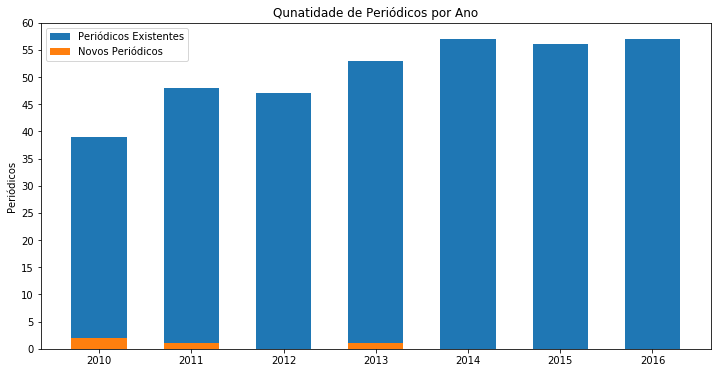

In [8]:
years = list(IF.columns)[1:]
counts = [len(IF[IF[i] >= 0 ]) for i in years]
news = [len(IF[IF[i] == 0 ]) for i in years]

ind = np.arange(len(years))
width = 0.6

plt.figure(figsize=(12, 6))
p1 = plt.bar(ind, counts, width, bottom=news)
p2 = plt.bar(ind, news, width)

plt.ylabel('Periódicos')
plt.title('Qunatidade de Periódicos por Ano')
plt.xticks(ind, years)
plt.yticks(np.arange(0, 65, 5))
plt.legend((p1[0], p2[0]), ('Periódicos Existentes', 'Novos Periódicos'))

plt.show()

### 1.2. Fator de Impacto 

## 2. Artigos

### 2.1. Quantidade de artigos "FORA DA BASE"

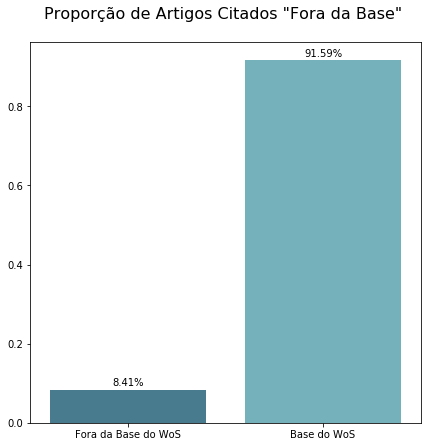

In [12]:
df_citations = citations
fora_da_base = (len(df_citations[df_citations.TARGET_A == 'FORA DA BASE'])/len(df_citations['TARGET_A']))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
sns.barplot(['Fora da Base do WoS', 'Base do WoS'], [fora_da_base,1-fora_da_base], palette='GnBu_d')
ax.set_title('Proporção de Artigos Citados "Fora da Base" \n')
ax.title.set_size(16)
for p, uniq in zip(ax.patches,[fora_da_base,1-fora_da_base]):
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.01, '{}%'.format(round(uniq * 100, 2)), ha="center")

Como a quantidade de artigos fora da base do WoS é baixa, vamos trabalhar apenas com os artigos pertencentes à base. 

In [14]:
df_citations_out = df_citations[df_citations.TARGET_A == 'FORA DA BASE']

In [15]:
df_citations = df_citations[df_citations.TARGET_A != 'FORA DA BASE']

## 3. Valores Únicos

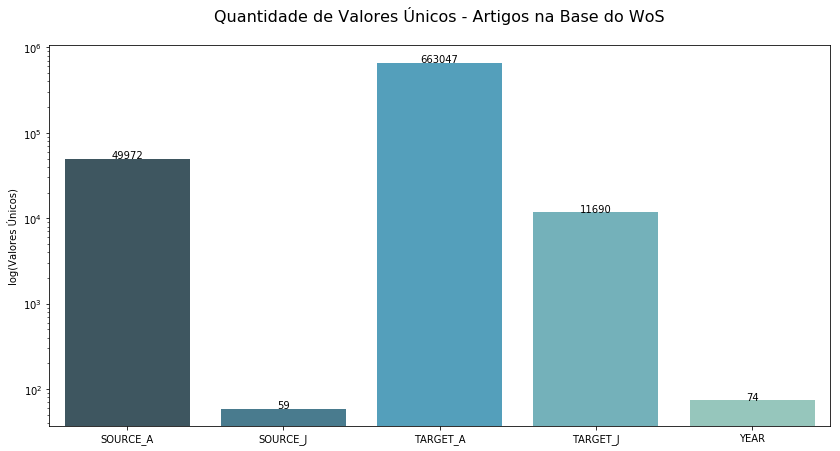

In [17]:
plt.figure(figsize=(14, 7))

cols = df_citations.columns

uniques = [len(df_citations[col].unique()) for col in cols]
ax = sns.barplot(cols, uniques, log=True, palette="GnBu_d")
ax.set(ylabel='log(Valores Únicos)', title='Quantidade de Valores Únicos - Artigos na Base do WoS\n')
ax.title.set_size(16)
for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.01, uniq, ha="center")

In [86]:
# print('Soma do Grau de Entrada: ' + str(sum(articles_cit.CITED_IN)))
# print('Soma do Grau de Saída Armazenado: ' + str(sum(articles_cit.CITED_OUT)))
# print('Soma do Grau de Saída Armazenado (FORA DA BASE): ' + str(sum(articles_cit.CITED_OUT_OB)))
# print('Soma do Grau de Saída Verdadeiro: ' + str(sum(articles_cit.CITED_OUT_T)))

## 4. Valores Mais Frequentes

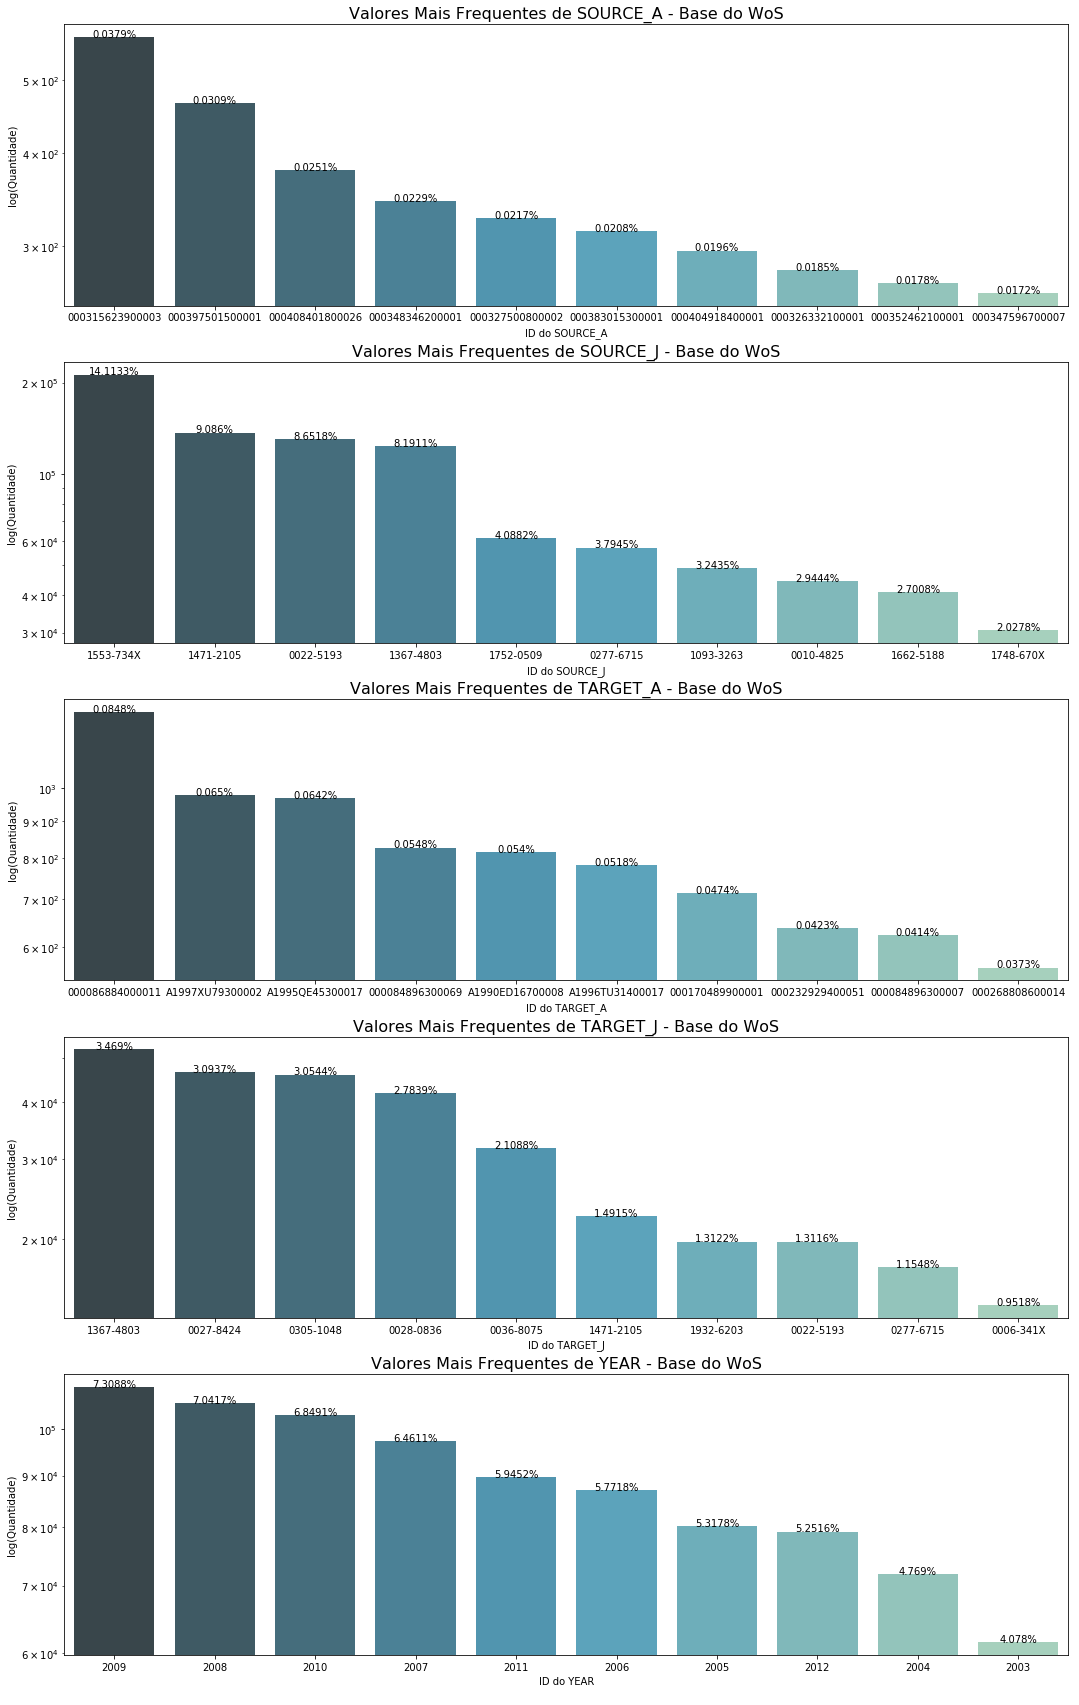

In [24]:
plt.figure(figsize=(18,30))

i = 1

for col in df_citations.columns:
    counts = pd.value_counts(df_citations[col].values, ascending=False)[0:10]
    indx = counts.index
    counts.reset_index(drop=True, inplace=True)

    plt.subplot(5,1,i)
    ax = sns.barplot(counts.index, counts.values, log=True, palette="GnBu_d")
    
    if col[-1] == 'A':
        ax.set_xticklabels((i.split('WOS:')[1] for i in indx), rotation=0)
    else:
        ax.set_xticklabels(indx, rotation=0)
        
    ax.set_xlabel('ID do ' +  str(col) + '\n')
    ax.set_ylabel("log(Quantidade)")
    ax.set_title("Valores Mais Frequentes de " + str(col) + ' - Base do WoS')
    ax.title.set_size(16)

    for p, vals in zip(ax.patches, [round(100*val/len(df_citations),4) for val in counts.values]):
        ax.text(p.get_x() + p.get_width()/2., p.get_height() + 0.01, '{}%'.format(vals), ha="center") 

    i = i + 1

## 5. A Rede de Citações (Periódicos)

https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf

http://snap.stanford.edu/class/cs224w-2012/nx_tutorial.pdf

In [48]:
# Para usar no Gephi
df_citations.to_csv('outputs/citations_base.csv', columns=['SOURCE_J', 'TARGET_J'], index=0,header=['Source', 'Target'])

![](Figuras/FIG3.png)

### 5.1. Gerando o grafo

In [31]:
G = nx.DiGraph()

In [49]:
i = list(df_citations.SOURCE_J)
j = list(df_citations.TARGET_J)

edges = []
for k in range(len(df_citations)):
    edges.append((x[k], y[k]))

In [42]:
print('Quantidade total de arestas: ' + str(len(edges)))

Quantidade total de arestas: 1508204


In [39]:
# Grafo direcionado ponderado pela quantidade de arestas do Journal_i para o Journal_j
G = nx.DiGraph((i, j, {'weight': v}) for (i, j), v in Counter(edges).items())

In [40]:
print('Número de arestas:' + str(G.number_of_edges()))
print('Número de vértices:' + str(G.number_of_nodes()))

Número de arestas:105795
Número de vértices:11690


### 5.2. Matriz de Adjacências

In [75]:
M = nx.to_scipy_sparse_matrix(G)
M

<11690x11690 sparse matrix of type '<class 'numpy.int32'>'
	with 105795 stored elements in Compressed Sparse Row format>

### 5.3. Distribuição de grau

https://gist.github.com/yamaguchiyuto/504eb5482fc73f046f6b

In [89]:
def plot_degree_distribution(data):
    plt.plot(range(len(data)),data,'bo')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Freq')
    plt.xlabel('Degree')
    plt.show()

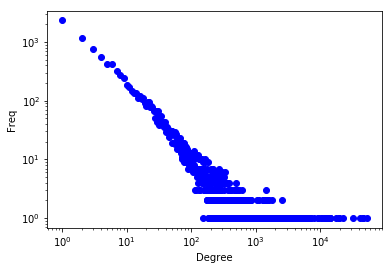

In [90]:
in_degrees = M.sum(0).A[0]
in_degree_distribution = np.bincount(in_degrees)
plot_degree_distribution(in_degree_distribution)

In [92]:
out_degrees = M.sum(1).T.A[0]
out_degree_distribution = np.bincount(out_degrees)